In [258]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

In [176]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 500

In [2]:
from sklearn.datasets import load_iris

# EP Mineração de Dados - SIN5017
### Twitter como corpus para análise de sentimentos de textos em política

In [268]:
def remove_marcacao(t):
    tweet = t
    tweet = re.sub('#[^\s]+','',tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    return tweet.strip()

In [343]:
def remove_links(t):
    return re.sub(r'http\S+', '', t, flags=re.MULTILINE).strip()

In [388]:
def remove_emotes(t):
    text = re.sub(r'(p*d*D*[\)]*[\(]*-?:-?[\(]*[\)]*p*D*d*)', '', t)
    text = re.sub(r'(p*d*D*[\)]*[\(]*-?;-?[\(]*[\)]*p*D*d*)', '', text)
    return text.strip()

## Dados

In [157]:
data = pd.read_csv('TweetsWithTheme.csv')

In [159]:
data = data[['tweet_text', 'sentiment', 'query_used']]

### Pré processamento

In [259]:
data.tweet_text = data.tweet_text.str.lower()
data.tweet_text = data.tweet_text.apply(unidecode)

In [260]:
data.query_used = data.query_used.str.lower()

In [261]:
queries = ['bolsonaro', 'ciro', 'haddad', 'marina', 'boulos', 'daciolo', 'meirelles', 'amoedo', 'vera', 'alvaro', 
           'eymael', 'alckmin', 'goulart']

In [262]:
s = "(data.query_used.str.contains('bolsonaro'))"

In [263]:
for q in queries[1:]:
    s += f" | (data.query_used.str.contains('{q}'))"

In [326]:
data_politicos = data[eval(s)].reset_index(drop = True)

In [327]:
nomes = []

for qu in data_politicos.query_used.values:
    for q in queries:
        if q in qu:
            nomes.append(q)


In [328]:
data_politicos = pd.concat([data_politicos, pd.DataFrame(nomes, columns = ['nome'])], axis = 1)

In [391]:
data_politicos_new = data_politicos.copy()

In [392]:
data_politicos_new.tweet_text = data_politicos_new.tweet_text.apply(remove_marcacao).apply(remove_links).apply(remove_emotes)

In [397]:
data_politicos_new = data_politicos_new.drop_duplicates()

In [399]:
data_politicos_new.to_csv('data_sentiment_pol_treated.csv')

## EDA

## Extração de características de texto

## Regressão Logística

a regressão logística modela a probabilidade de cada input pertencer a uma categoria. Para gerar as probabilidades a regressão logística usa a função sigmoid que retorna valores entre 0 e 1 para todos os valores de X

$$ h_ \theta (x) = g(\theta^Tx) $$

$$ z = \theta^Tx $$

$$ g(z) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-z} }  $$

In [21]:
#função sigmoid que é o diferencial da regressão logística para a regressão linear simples
#ela coloca os valores de uma regressão linear num intervalo entre 0 e 1, sendo possível realizar a classificação
#fazendo uso de um threshold de probabilidade para definir a qual classe o algoritmo deve pertencer
def funcao_sigmoid(z):
    return 1/(1 + np.exp(-z))

as funções possuem parâmetros/pesos($\theta$) e precisamos encontrar os melhores valores para eles. Começamos com valores aleatórios ou 0 para esses parâmetros e precisamos de alguma forma para medir a performance usando esses parâmetros. Essa medida é calculada utilizando a função de custo

$$ h = g(X\theta) $$


<img src="Matlab_Plot_Logistic_Regression_Cost_Function.png" align="center"/>

Assim, o custo de um exemplo x

$$custo(h(x), y) = -ylog(h) - (1-y)log(1-h) $$

O custo para todos os exemplos de treino é denotado como $J(\theta)$ e é calculado como a média dos erros individuais.

$$ J(\theta) = \frac{1}{m}(-y^Tlog(h) - (1-y)^Tlog(1-h)) $$

In [22]:
def custo(h, y):
    return 1/m * sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

**Gradiente Descendente**

Queremos minimizar a função loss e para isso modificamos os pesos aumentando/diminuindo. Para sabermos quais pesos diminuir e quais pesos aumentar dado que inicializamos com pesos aleatórios é derivando parcialmente a função de loss para cada peso. Essa derivada indica como a loss muda se modificamos os pesos.

$$ \frac{\delta J(\theta)}{\delta \theta _j} = \frac{1}{m}X^T(g(X \theta) - y)$$

In [5]:
def gradiente(X, y, h):
    return np.dot(X.T, (h - y)) / y.shape[0]

In [39]:
iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

In [40]:
m , n = X.shape[0], X.shape[1]

In [41]:
#X= np.append(np.ones((m,1)),X,axis=1)
y=y.reshape(m,1)

**teste**

In [44]:
initial_theta = np.zeros((n,1))

In [45]:
pred = funcao_sigmoid(np.dot(X, initial_theta))

In [46]:
custo(pred, y)

array([0.69314718])

In [47]:
gradiente(X, y, pred)

array([[-1.253],
       [-0.386]])

Agora precisamos otimizar o algoritmo utilizando gradiente descendente

In [67]:
def grad_descendente(X, y, theta, alpha, num_iter):
    """
    pega os dados de treino e seus valores de classe com o peso theta e atualiza o theta pelas iterações do gradiente
    descendente com uma taxa de aprendizado alpha
    """
    historico_loss = []

    for i in range(num_iter):
        pred = funcao_sigmoid(np.dot(X, theta))
        loss = custo(pred, y)
        grad = gradiente(X, y, pred)
        
        theta = theta - (alpha * grad)
        historico_loss.append(loss[0])
        
    return theta, historico_loss

In [68]:
grad_descendente(X, y, initial_theta, .01, 1000)

(array([[ 0.91042717],
        [-1.43609693]]),
 [0.6931471805599464,
  0.6768735561256416,
  0.6638702282657098,
  0.6534477007983384,
  0.6450595309329172,
  0.6382753009765096,
  0.6327570851904806,
  0.6282398941243753,
  0.6245158856318472,
  0.6214218446585077,
  0.6188293644646308,
  0.6166371959490946,
  0.6147653060034663,
  0.6131502683765259,
  0.61174168694273,
  0.6104994163054955,
  0.6093913975383431,
  0.6083919686992829,
  0.6074805423094884,
  0.6066405670721127,
  0.605858710325157,
  0.6051242124037574,
  0.6044283752932593,
  0.6037641565120625,
  0.6031258457082156,
  0.6025088064701947,
  0.6019092697075739,
  0.601324167928769,
  0.6007510020407328,
  0.6001877340778597,
  0.5996327006546994,
  0.5990845430204125,
  0.598542150441677,
  0.598004614307831,
  0.5974711908779439,
  0.5969412710053773,
  0.596414355505113,
  0.5958900350913475,
  0.5953679740218415,
  0.5948478967525203,
  0.5943295770396003,
  0.5938128290338592,
  0.5932974999980295,
  0.592783464

### Unindo todos os métodos em uma única classe RegressaoLogistica

In [112]:
iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

In [113]:
y=y.reshape(m,1)

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [104]:
#utilizando nomenclaturas do sklearn
class RegressaoLogistica:
    def __init__(self, taxa_aprendizado = .01, num_iter = 1000, tem_bias = True):
        self.alpha = taxa_aprendizado
        self.num_iter = num_iter
        self.tem_bias = tem_bias
        
    def __add_bias(self, X):
        #adiciona um neuronio na camada de entrada correspondente ao bias
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)
    
    def __funcao_sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def __custo(self, h, y):
        return 1/m * sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    
    def __gradiente(self, X, y, h):
        return np.dot(X.T, (h - y)) / y.shape[0]
    
    def fit(self, X, y):
        if self.tem_bias:
            X = self.__add_bias(X)
        
        #inicializacao dos pesos
        self.theta = np.zeros((X.shape[1], 1))
        #vetor para armazenar os valores de loss a cada iteracao
        historico_loss = []
        
        #iterando num_iter vezes no gradiente descendente
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            pred = funcao_sigmoid(z)
            loss = custo(pred, y)
            
            grad = gradiente(X, y, pred)
            self.theta = self.theta - (self.alpha * grad)
            
            historico_loss.append(loss[0])
        
        return historico_loss
    
    def predict_proba(self, X):
        if self.tem_bias:
            X = self.__add_bias(X)
            
        z = np.dot(X, self.theta)
        pred = self.__funcao_sigmoid(z)
        return pred
    
    def predict(self, X, limiar = .5):
        pred = self.predict_proba(X) >= limiar 
        int_pred = [[int(p[0])] for p in pred]
        return int_pred

In [122]:
reglog = RegressaoLogistica(taxa_aprendizado= .01, num_iter= 1000, tem_bias= True)

In [123]:
reglog.fit(X_train, y_train)

[0.4852030263919622,
 0.4739766328817016,
 0.4650326263477366,
 0.45788216973169393,
 0.4521395890596722,
 0.4475024294244522,
 0.4437342394790085,
 0.4406503683345104,
 0.43810656967583833,
 0.4359900152886728,
 0.43421228293525344,
 0.432703917731875,
 0.43141022644809446,
 0.43028802805557864,
 0.42930314167786143,
 0.428428441604401,
 0.4276423480632226,
 0.42692765307872316,
 0.4262706044230815,
 0.4256601888148582,
 0.4250875693521151,
 0.42454564268996675,
 0.4240286894729082,
 0.4235320976202873,
 0.4230521427042268,
 0.42258581320557115,
 0.4221306711508978,
 0.42168474072242235,
 0.42124641904347365,
 0.4208144045885857,
 0.4203876396349022,
 0.4199652639253384,
 0.4195465773029887,
 0.4191310095380746,
 0.4187180959318838,
 0.4183074575685532,
 0.41789878531207364,
 0.4174918268255226,
 0.4170863760323155,
 0.4166822645530635,
 0.4162793547424853,
 0.41587753402353367,
 0.41547671027420846,
 0.4150768080693455,
 0.4146777656173534,
 0.41427953226222336,
 0.4138820664456346,


In [124]:
y_pred = reglog.predict(X_test)

In [132]:
y_pred_proba = reglog.predict_proba(X_test)

In [144]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

acuracia

In [128]:
accuracy_score(y_test, y_pred)

0.9333333333333333

precisao

In [129]:
precision_score(y_test, y_pred)

0.9090909090909091

recall

In [130]:
recall_score(y_test, y_pred)

1.0

roc auc score

In [134]:
roc_auc_score(y_test, y_pred_proba)

0.9977777777777779

curva roc

In [147]:
import matplotlib.pyplot as plt

In [150]:
reglog.fit(X, y)

[0.6931471805599464,
 0.6766315269371209,
 0.6635047640993964,
 0.6530372936044441,
 0.6446542470219195,
 0.6379054845193581,
 0.6324396638495651,
 0.627982855128594,
 0.6243214040081865,
 0.6212884411569689,
 0.6187533758614585,
 0.6166137634875225,
 0.6147890290537196,
 0.6132156272200373,
 0.6118433075091743,
 0.6106322276307878,
 0.6095507171857155,
 0.6085735405159929,
 0.607680543306429,
 0.6068555949306816,
 0.6060857593615553,
 0.605360643268955,
 0.6046718819175698,
 0.60401273257982,
 0.6033777521053993,
 0.6027625405710689,
 0.6021635369750412,
 0.6015778560411229,
 0.6010031575854441,
 0.6004375417433615,
 0.5998794647845068,
 0.5993276713566932,
 0.5987811398680458,
 0.5982390383969851,
 0.5977006890541023,
 0.5971655391410836,
 0.5966331377845774,
 0.5961031169865877,
 0.5955751762424243,
 0.5950490700440322,
 0.5945245977196495,
 0.5940015951671981,
 0.5934799281241474,
 0.5929594866850812,
 0.5924401808332862,
 0.5919219367970517,
 0.5914046940771734,
 0.590888403021052

In [152]:
a = reglog.predict_proba(X)

In [153]:
fpr, tpr, _ = roc_curve(y, a)
roc_auc = auc(fpr, tpr)

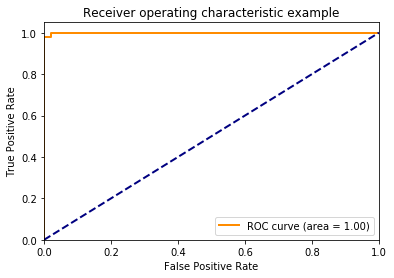

In [154]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
mostrar o que o modelo erra, onde tá o gap do modelo. colocar matriz de confusao